# Unsupervised Clustering using Hidden Markov Model 

## Import packages

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from hmmlearn import hmm
from simpl_eeg import (
    connectivity,
    eeg_objects,
    raw_voltage,
    topomap_2d,
    topomap_3d_brain,
    topomap_3d_head,
)
import plotly.graph_objects as go

C:\Users\Yiki\miniconda3\envs\capstone\lib\site-packages\ipykernel\parentpoller.py:110: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


In [2]:
%matplotlib inline

## Why Hidden Markov Model

A Markov model assumes that the future is conditionally independent of the past given the present (Daniel & James, 2020), with the probability shown below:
$$P(S_i |S_1...S_{i−1}) = P(S_i|S_{i−1})$$ where $S_i$ is the state at time i.

A hidden Markov model (HMM) relates a sequence of observations to a sequence of hidden states that explain the observations (Daniel & James, 2020). For the EEG data, the sequence of observations is the EEG data per time frame and the sequence of hidden states would be the brain states in the dataset. Since the brain activities at time $i$ is less likely to highly correlate to brain activities before time $i-1$, the Markov model assumption would be satisfied at this case and therefore we would like to try to apply the hidden Markov model to EEG data.

Since we don't have labeled data or pre-defined brain states, we would need to use unsupervised HMM for this task. The process of finding the sequence of hidden states given the sequence of observations using HMM is called decoding (Daniel & James, 2020) and the `Viterbi` algorithm is commonly used for decoding. Therefore, for this notebook, I would use the `Viterbi` algorithm in the HMM model for finding the potential brain states. 

A hidden Markov model consists of 5 components:
- the state space: a set of hidden states
- the sequence of observation
- the transition probability matrix: the probability transitioning from state $i$ to state $j$
- the emission probabilities: conditional probabilities for all observations given a hidden state
- the initial probability over states: the probability for the Markov model starts at state $i$

The goal for this task is to explore the set of hidden states (the state space) and the transition probability matrix of the EEG data using hidden Markov model. 

## Read in the Data

In [3]:
raw_full = mne.io.read_raw_eeglab("../../data/927/fixica.set")

Reading C:\Users\Yiki\Documents\UBC\MDS\Homework\capstone\simpl_eeg_capstone\data\927\fixica.fdt


<ipython-input-3-99b5e4cf8c83>:1: RuntimeWarning: Data file name in EEG.data (927 fix ica correct.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  raw_full = mne.io.read_raw_eeglab("../../data/927/fixica.set")


In [4]:
entire_df = raw_full.to_data_frame()

In [5]:
channel_names = raw_full.ch_names

In [6]:
epoch = eeg_objects.Epochs("../../data/927").epoch

Reading C:\Users\Yiki\Documents\UBC\MDS\Homework\capstone\simpl_eeg_capstone\data\927\fixica.fdt


c:\users\yiki\documents\ubc\mds\homework\capstone\simpl_eeg_capstone\simpl_eeg\eeg_objects.py:52: RuntimeWarning: Data file name in EEG.data (927 fix ica correct.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  self.raw = mne.io.read_raw_eeglab(folder_path+"/"+file_name+".set")


Not setting metadata
Not setting metadata
33 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 33 events and 2049 original time points ...
0 bad epochs dropped


## EDA

According to the EDA in the [intro page](https://ubc-mds.github.io/simpl_eeg_capstone/clustering.html), the EEG data is following Gaussian distribution for each electrode node, therefore, a GaussianHMM model would be used. However, there are clearly some outliers in the data. My next step is to remove the outliers of the data based on the expertise suggestions from the partner to keep EEG data which falls into (-50, 50) range.

## Data preprocessing

In [7]:
# drop rows where all values are zero
cleaned_df = entire_df.loc[(entire_df[channel_names] != 0).all(axis=1)]

# drop the outliers of dataset (only keep rows where EEG voltage is between -50 to 50)
df_no_outliers = cleaned_df.loc[
    ((cleaned_df[channel_names] <= 50) & (cleaned_df[channel_names] >= -50)).all(axis=1)
]

# chunk the data into per second (each second has 2048 readings (rows))
df_second = np.split(df_no_outliers, range(2048, len(df_no_outliers), 2048))


# for each second, randomly sampled 10 time stamps (the original dataset is too big, wants to sample a smaller dataset for exploration)
time_jump = 50
df_second_resample = {}
for second in range(len(df_second)):
    df_second_resample[second] = (
        df_second[second]
        .sample(time_jump, random_state=2020, axis=0)
        .sort_values(by="time")
    )
df_resampled = pd.concat([values for key, values in df_second_resample.items()])

## Building Models

Based on the suggestion from the partner, we would like to explore the data in per 5 second interval. 

In [8]:
five_second_df = np.split(
    df_resampled, range(time_jump * 5, len(df_resampled), time_jump * 5)
)

In [9]:
# since HMM model only takes in (n_sample, n_feature) array, reshape the data into an array where each sample has 5 seconds data
chunked_list = []
for i in range(len(five_second_df)):
    chunked_list.append(np.array(five_second_df[i].iloc[:, 1:]).flatten())
chunked_array = np.array(chunked_list)

As mentioned above, the EEG data follows Gaussian distribution and is continous, we would use the `GaussianHMM` model from `hmmlearn` package. Since we don't know the number of brain states from the model, we would like to start with some random numbers.

In [10]:
# n_components is the number of hidden states (number of brain states)
chunked_model = hmm.GaussianHMM(n_components=14)

In [11]:
chunked_model.fit(chunked_array)

GaussianHMM(n_components=14)

In [12]:
chunked_result = chunked_model.decode(chunked_array, algorithm="viterbi")

### Check model output

In [13]:
# the metric that hmmlearn package itself used to evaluate the model
print(
    f"The log probability for this {chunked_model.n_components}-cluster model is {chunked_result[0]:0.4f}"
)

The log probability for this 14-cluster model is -18314533.5217


In [14]:
print(f"The starting probability for this model is: {chunked_model.startprob_}")

The starting probability for this model is: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [15]:
print(f"The transmission probability matrix of this model is: \n")
pd.DataFrame(chunked_model.transmat_)

The transmission probability matrix of this model is: 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.018868,0.188684,0.056605,0.132079,0.132079,0.113211,0.132052,0.000000,0.037737,1.493079e-232,0.056605,0.094342,0.000000,0.037737
1,0.045455,0.081819,0.045455,0.118184,0.218170,0.127275,0.100002,0.000000,0.018182,6.363736e-02,0.009091,0.145457,0.000000,0.027273
2,0.041667,0.145833,0.062500,0.145833,0.041667,0.145834,0.062500,0.000000,0.000000,6.249970e-02,0.083333,0.166667,0.000000,0.041667
3,0.075000,0.075000,0.033333,0.075000,0.108333,0.166839,0.149828,0.008333,0.000000,5.000003e-02,0.066666,0.166667,0.000000,0.025000
4,0.047337,0.065089,0.047337,0.130177,0.201183,0.124260,0.047337,0.000000,0.017751,3.550296e-02,0.071006,0.159764,0.000000,0.053254
5,0.048943,0.146828,0.041951,0.118868,0.153832,0.112010,0.041961,0.000000,0.006992,4.894267e-02,0.062926,0.139836,0.000000,0.076910
6,0.052646,0.118430,0.026323,0.144762,0.118453,0.170864,0.039484,0.000000,0.000000,5.264589e-02,0.052646,0.131615,0.013161,0.078969
7,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
8,0.062500,0.000000,0.125000,0.125000,0.062500,0.125000,0.000000,0.000000,0.000000,0.000000e+00,0.250000,0.125000,0.000000,0.125000
9,0.080000,0.100000,0.140000,0.140000,0.200000,0.100000,0.080000,0.000000,0.000000,0.000000e+00,0.020000,0.100000,0.000000,0.040000


#### Interpretation of the output

- Based on the starting probability, the dataset always start with the same brain state with probability equals to 1.
- It is hard to tell whether there are any dominating brain states from the transmission probability. 

In [16]:
# add lables back to the df
df_result = five_second_df.copy()
for i in range(len(df_result)):
    df_result[i] = df_result[i].assign(cluster=chunked_result[1][i])

In [17]:
df_result = pd.concat([df_result[i] for i in range(len(df_result))])

In [18]:
df_result.head()

,time,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,...,Pz,F4,C4,P4,F8,T4,T6,O1,O2,cluster
14,7,-5.416321,-8.702773,12.929683,-4.267407,-17.012657,-19.657581,-7.856932,4.599534,-16.746788,...,8.995889,-18.678459,-2.681060,3.765667,-1.263025,-6.090218,-3.464389,1.173670,1.137339,5
54,26,-12.013180,-14.579842,2.910196,-7.934999,-19.046343,-24.195089,-13.608892,-8.537370,-24.515978,...,-3.992567,-26.971264,-11.818206,-6.980398,-4.949781,-8.873546,-12.382152,-5.388040,-19.186934,5
103,50,-9.335183,-11.704183,12.291105,-6.097588,-19.876202,-20.937525,-13.204792,-1.552722,-17.927401,...,-4.384526,-22.728746,-10.506824,-6.928967,-1.555773,-8.912907,-14.485776,-5.407309,-18.228041,5
221,108,-7.354957,-9.589952,-6.286791,-10.872064,-20.493488,-22.544647,-13.147114,-9.828817,-14.353374,...,-9.426474,-21.085129,-11.508833,-12.529051,-5.620958,-7.835037,-10.463814,-10.011393,-17.232655,5
238,116,-10.382986,-10.848916,1.851252,-5.061864,-15.924600,-7.336891,-4.925910,-6.326971,-13.854161,...,-10.371316,-19.279264,-14.257339,-13.585352,0.204445,-10.267734,-23.560305,-7.179190,-24.511086,5


### Output visualization

#### Reason why I use visualization methods to assess the output

- The log probability that HMM model itself provides doesn't provide contents to evalute the model performance.
- It is hard to evaluate the model performance by only looking at the raw voltage values.
- Visualizing the EEG data seems to be the most intuitive way to check the output.
- There is not a good way to determine the optimal `n_components` (which is the number of brain states in the data) of the HMM model. The best way is to check the output for now.

#### Visualize the average voltage for each cluster in the resampled dataset

In [19]:
cluster_dict = {}
for i in range(chunked_model.n_components):
    cluster_dict["cluster_" + str(i)] = df_result[df_result["cluster"] == i]

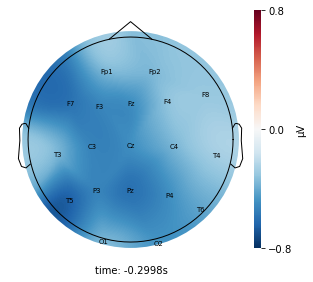

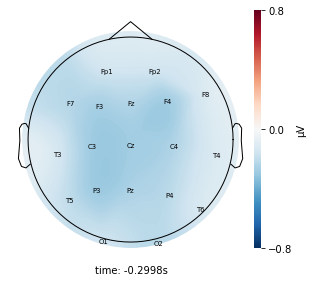

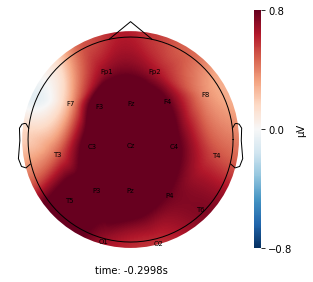

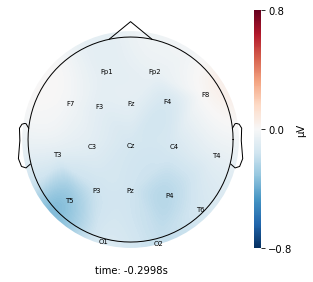

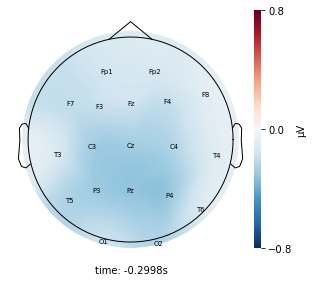

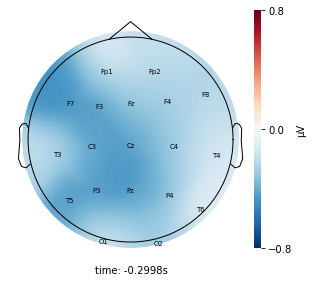

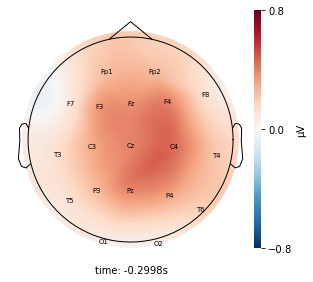

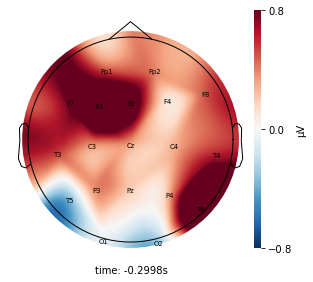

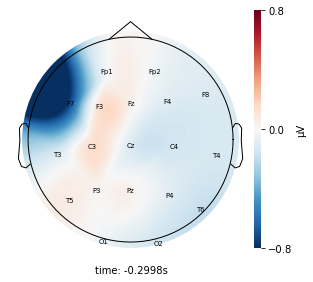

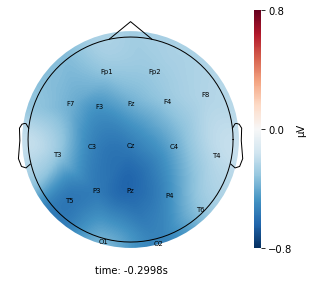

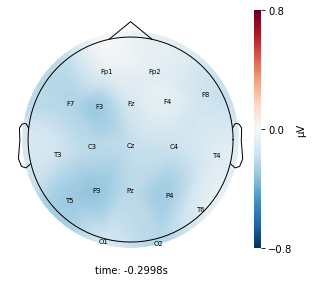

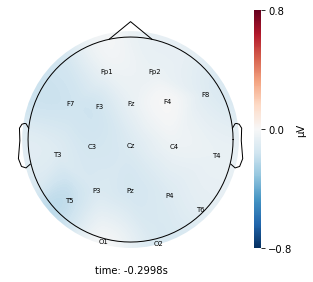

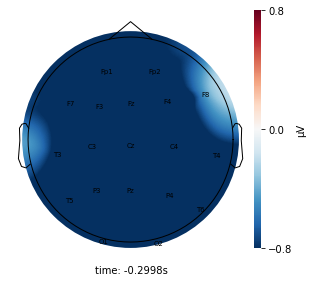

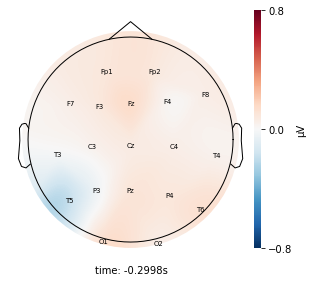

In [20]:
for cluster_key, cluster in cluster_dict.items():
    cluster_key = topomap_2d.plot_topomap_2d(
        epoch,
        cluster.iloc[:, 1:20].mean().values * 1e-6,
        mark="channel_name",
        cmin=-0.8,
        cmax=0.8,
    )

#### Interpretation

- Each topographic heatmap shows the **average raw voltage** for each electrode node for a specific cluster.
- Although each clusters does show different patterns, it is hard to define the brain states by just looking at it.
- Although there are different patterns in each clusters, the differences are not significant. 

#### Label the original dataset and visualize the outcome

Since we were only drawing a random sample of 50 time stamps for each second for fitting the model, we wanted to add the cluster labels back to the entire dataset to check the outcome to see whether they make a good representation of each second. If the cluster outcomes look very different from the resampled data outcomes, we might want to increase the sample size.

In [21]:
# add lables back to the entire_df
entire_df_result = np.split(df_no_outliers, range(10240, len(df_no_outliers), 10240))
for i in range(len(entire_df_result)):
    entire_df_result[i] = entire_df_result[i].assign(cluster=chunked_result[1][i])

entire_df_result = pd.concat(
    [entire_df_result[i] for i in range(len(entire_df_result))]
)

In [22]:
# separate the clusters for the entire dataset
entire_cluster_dict = {}
for i in range(chunked_model.n_components):
    entire_cluster_dict["cluster_" + str(i)] = entire_df_result[
        entire_df_result["cluster"] == i
    ]

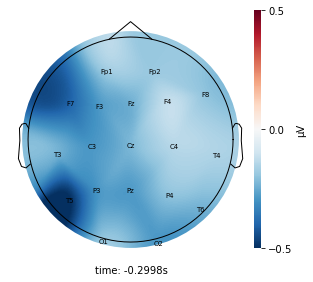

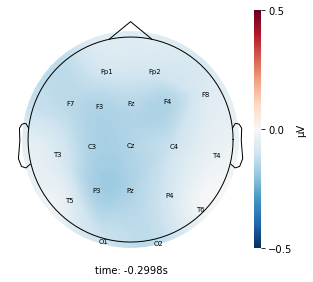

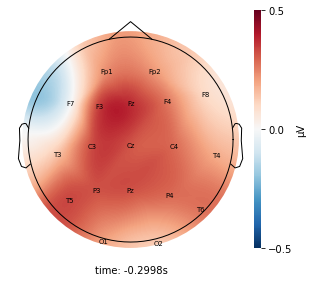

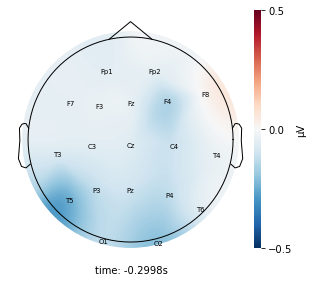

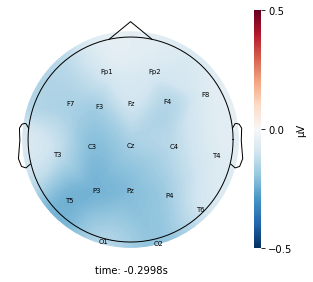

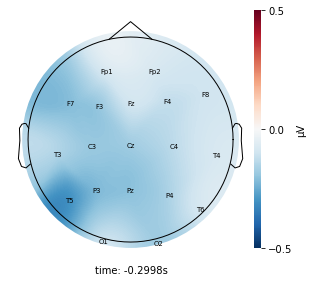

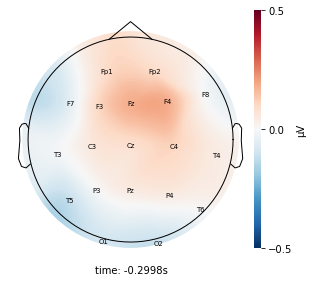

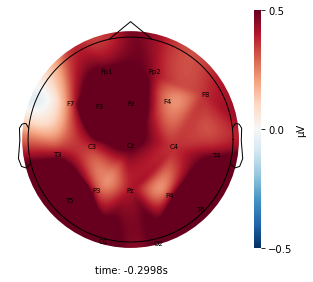

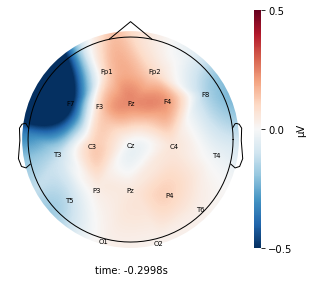

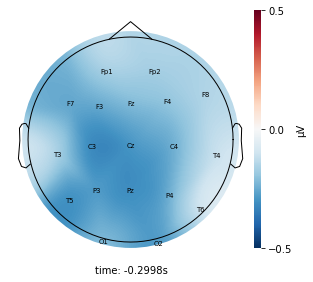

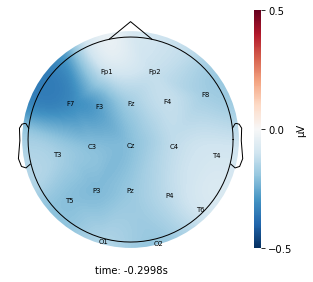

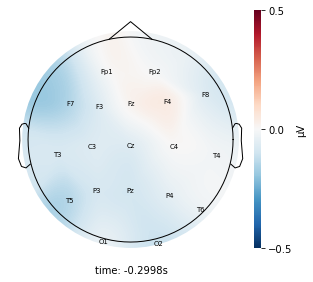

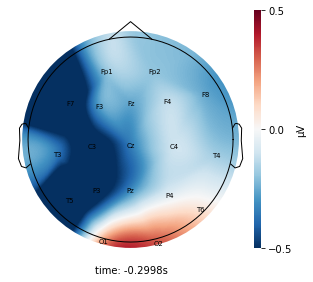

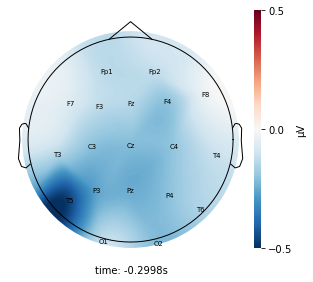

In [23]:
for cluster_key, cluster in entire_cluster_dict.items():
    cluster_key = topomap_2d.plot_topomap_2d(
        epoch,
        cluster.iloc[:, 1:20].mean().values * 1e-6,
        mark="channel_name",
        cmin=-0.5,
        cmax=0.5,
    )

#### Interpretation

- Although the colors don't exactly match with the resampled data, the patterns seem to be consistent. 50 randomly sampled time stamps data seems to serve as a good representation for the entire second.

#### Visualize the raw voltage plot for a couple seconds

Since just assessing the outcome using the topographic heatmap doesn't provide a lot of values, I would like to generate a raw voltage plot to visualize the output. However, since the `raw_voltage` function of the `simpl_eeg` package doesn't accept data frame and don't have access to overwrite the epoch data to include the cluster label, I will use the line plot from `plotly` package. Since the entire dataset is too large, only looking at a screenshot of a five second time period for each clusters. 

In [24]:
color_list = [
    "red",
    "yellow",
    "green",
    "blue",
    "black",
    "brown",
    "grey",
    "chocolate",
    "crimson",
    "coral",
    "darkgoldenrod",
    "orange",
    "purple",
    "burlywood",
    "cornflowerblue",
    "darkblue",
    'darkviolet',
    "darkorange",
    'darkgray'
]

In [26]:
color_count = 0
for cluster, df in entire_cluster_dict.items():
    sliced_df = df.iloc[:10240]
    single_plot_df = sliced_df.copy()
    for i, col in enumerate(single_plot_df.columns):
        if col != "cluster":
            single_plot_df[col] = single_plot_df[col] + 100 * i
    single_plot_df["time"] = single_plot_df.index
    single_plot_df = single_plot_df.melt(id_vars=["cluster", "time"])
    line_fig = go.Figure()
    line_fig.add_trace(
        go.Scatter(
            x=single_plot_df["time"],
            y=single_plot_df["value"],
            mode="lines",
            name=cluster, 
            line=dict(color=color_list[color_count]),
        )
    )
    line_fig.update_layout(title=cluster)
    line_fig.update_xaxes(showticklabels=False)
    line_fig.update_yaxes(title="Channel", showticklabels=False)
    static_file_path_png = "instruction_imgs/clustering_img/"+ cluster + ".png"
    line_fig.write_image(static_file_path_png)
#     line_fig.show()
    color_count += 1

#### Interpretation

- **The time interval for each of the clusters above is 5 seconds.**
- There are clearly differences in each of clusters when looking at the raw voltage plot. However, it is hard to interpret whether these patterns are providing any specific information without EEG background knowledge.
- Within the same cluster, the brain activities show similar patterns across different electrode nodes (not exactly the same but similar). 

## Comments about the Hidden Markov Model

- It is really hard to interpret the model and to tune the hyperparameter (`n_components`) for the model.
- Model performance is hard to assess and requires a lot of background knowledge.

## Next Steps

Due to the limited time and efforts that we could allocate to this task, there are other potential useful approaches to try for this task but haven't been implemented yet. 

- Data preprocessing: 
    - instead of sampling only 50 time stamps per second, increase the sampling rate so that it could capture more dynmaics from each second to provide a more accurate result.
    - instead of looking at the entire dataset, subset the dataset into epoches and then use epoched data to fit the model.


- Feature engineering: instead of only using the raw voltage data for model input, include some engineered features that could provide a better representation of the temporal dependencies of the data such as the following:
    - apply rolling mean for each 5 second data chunks rather than simply taking the mean of each 5 second data chunks
    - use the sliding window approach to slide the per 5 second data 


- Literature review: read through more literature articles to define a better metric to evaluate the model

- Hyperparameter tuning: currently, there isn't a better way to find the optimal `# of cluster` in the model other than finish fitting the model and visualizing the output to check. Use the metric that we could locate from the previous objective to tune the hyperparameter.

## Attribution

- Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright © 2020. All
rights reserved. Draft of December 30, 2020.
